In [1]:
import pandas as pd
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from model import LSTM_Autoencoder

# --- STYLE CONFIG ---
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (15, 6)

# --- 1. DEFINE PATHS & CONSTANTS ---
WINDOW_SIZE = 30
MODEL_PATH = "lstm_model.pth"
META_PATH = "train_meta.pkl"
DATA_PATH = "data/test_anomaly.csv"  # Ensure this matches your folder structure

# --- 2. LOAD RESOURCES (Model & Threshold) ---
try:
    with open(META_PATH, 'rb') as f:
        meta = pickle.load(f)
        scaler = meta['scaler']
        threshold = meta['threshold']
    print(f"✅ Metadata loaded. Threshold: {threshold:.4f}")

    model = LSTM_Autoencoder(input_dim=3, hidden_dim=64, latent_dim=4)
    model.load_state_dict(torch.load(MODEL_PATH))
    model.eval()
    print("✅ Model loaded.")
except FileNotFoundError:
    print("❌ ERROR: Model or Meta file not found. Did you run main_train.py?")

# --- 3. LOAD DATA (The missing part!) ---
try:
    df_test = pd.read_csv(DATA_PATH)
    print(f"✅ Test Data loaded: {len(df_test)} rows.")
except FileNotFoundError:
    print(f"❌ ERROR: Could not find {DATA_PATH}")

# --- 4. PRE-CALCULATE EVERYTHING ---
# We do the heavy lifting here so the graphs are fast
if 'df_test' in locals():
    # Helper: Sliding Window
    def create_sliding_windows(data, window_size):
        sequences = []
        for i in range(len(data) - window_size):
            sequences.append(data[i : i + window_size])
        return np.array(sequences)

    # Prepare Input
    test_values = df_test[["speed", "gas", "brake"]].values
    test_scaled = scaler.transform(test_values)
    X_test = create_sliding_windows(test_scaled, WINDOW_SIZE)
    X_test_tensor = torch.FloatTensor(X_test)

    # Prepare Labels
    raw_labels = df_test["label"].values
    label_windows = create_sliding_windows(raw_labels, WINDOW_SIZE)
    y_test = (label_windows.sum(axis=1) >= 8).astype(int)

    # Run Inference (Get the Error Scores)
    print("⏳ Running inference on full test set...")
    with torch.no_grad():
        reconstructed = model(X_test_tensor)
        mse_test = np.mean(np.power(X_test_tensor.numpy() - reconstructed.numpy(), 2), axis=(1, 2))
    print("✅ Inference complete. Ready to plot.")

✅ Metadata loaded. Threshold: 0.0296
✅ Model loaded.
✅ Test Data loaded: 4000 rows.
⏳ Running inference on full test set...
✅ Inference complete. Ready to plot.


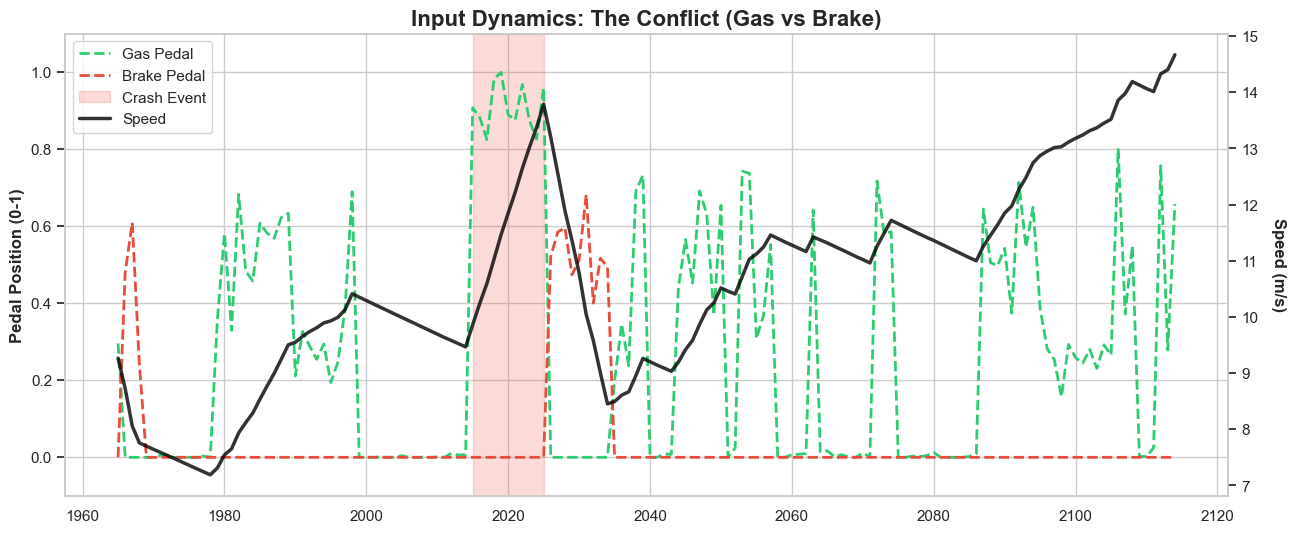

In [2]:
# --- IMPROVED PLOT 1: DUAL AXIS INPUT ---
# Pick a window that actually has a crash (e.g., the first one found)
anom_indices = df_test.index[df_test['label'] == 1].tolist()
if anom_indices:
    # Zoom in: 50 steps before first crash -> 100 steps after
    center = anom_indices[0]
    start = max(0, center - 50)
    end = min(len(df_test), center + 100)
    subset = df_test.iloc[start:end]
else:
    subset = df_test.iloc[:150] # Fallback if no crash

fig, ax1 = plt.subplots(figsize=(15, 6))

# Axis 1: Pedals (0 to 1 range)
ax1.plot(subset.index, subset["gas"], color="#2ecc71", linestyle="--", linewidth=2, label="Gas Pedal")
ax1.plot(subset.index, subset["brake"], color="#e74c3c", linestyle="--", linewidth=2, label="Brake Pedal")
ax1.set_ylabel("Pedal Position (0-1)", fontweight='bold')
ax1.set_ylim(-0.1, 1.1)

# Axis 2: Speed (Higher magnitude)
ax2 = ax1.twinx()
ax2.plot(subset.index, subset["speed"], color="black", linewidth=2.5, alpha=0.8, label="Speed")
ax2.set_ylabel("Speed (m/s)", fontweight='bold', rotation=270, labelpad=20)
ax2.grid(False) # Turn off grid for 2nd axis to look cleaner

# Highlight Anomalies correctly (step by step)
# We fill red only where label == 1
ax1.fill_between(subset.index, 0, 1, where=(subset["label"] == 1), 
                 color="#e74c3c", alpha=0.2, transform=ax1.get_xaxis_transform(), label="Crash Event")

# Combined Legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

plt.title("Input Dynamics: The Conflict (Gas vs Brake)", fontsize=16, fontweight='bold')
plt.show()

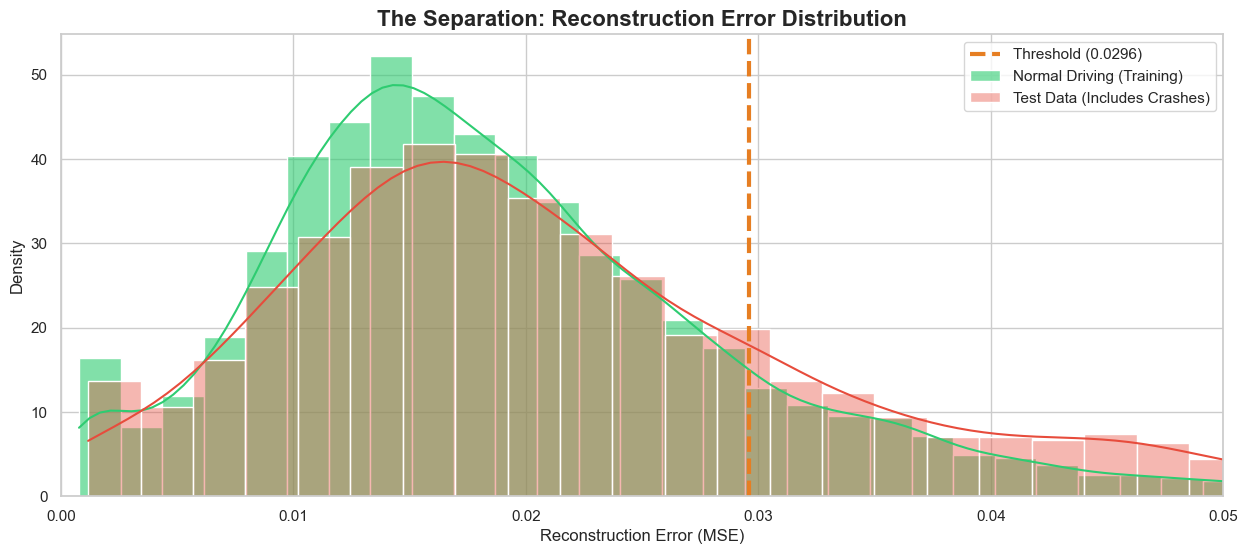

In [5]:
# --- PREPARE DATA FOR HISTOGRAM ---
# --- DEFINE COLORS (Missing Part) ---
COLORS = {
    'normal': '#2ecc71',   # Green
    'anomaly': '#e74c3c',  # Red
    'threshold': '#e67e22' # Orange
}
# 1. Load Normal Data (Reference)
df_normal = pd.read_csv("data/train_normal.csv")
norm_scaled = scaler.transform(df_normal[["speed", "gas", "brake"]].values)
X_norm = create_sliding_windows(norm_scaled, WINDOW_SIZE)
X_norm_tensor = torch.FloatTensor(X_norm)

# 2. Load Test Data (Contains Anomalies)
test_scaled = scaler.transform(df_test[["speed", "gas", "brake"]].values)
X_test = create_sliding_windows(test_scaled, WINDOW_SIZE)
X_test_tensor = torch.FloatTensor(X_test)

# 3. Get Reconstruction Errors
with torch.no_grad():
    # Normal Errors
    rec_norm = model(X_norm_tensor)
    mse_norm = np.mean(np.power(X_norm_tensor.numpy() - rec_norm.numpy(), 2), axis=(1, 2))
    
    # Test Errors
    rec_test = model(X_test_tensor)
    mse_test = np.mean(np.power(X_test_tensor.numpy() - rec_test.numpy(), 2), axis=(1, 2))

# --- PLOT 2: ERROR DISTRIBUTION ---
plt.figure(figsize=(15, 6))

# Plot Normal Error Distribution
sns.histplot(mse_norm, bins=50, kde=True, color= COLORS['normal'], label='Normal Driving (Training)', stat="density", alpha=0.6)

# Plot Test Error Distribution
sns.histplot(mse_test, bins=50, kde=True, color=COLORS['anomaly'], label='Test Data (Includes Crashes)', stat="density", alpha=0.4)

# Threshold Line
plt.axvline(threshold, color=COLORS['threshold'], linestyle='--', linewidth=3, label=f'Threshold ({threshold:.4f})')

plt.title("The Separation: Reconstruction Error Distribution", fontsize=16, fontweight='bold')
plt.xlabel("Reconstruction Error (MSE)")
plt.ylabel("Density")
plt.xlim(0, 0.05) # Limit X-axis to zoom in on the separation (adjust if your errors are larger)
plt.legend()
plt.show()

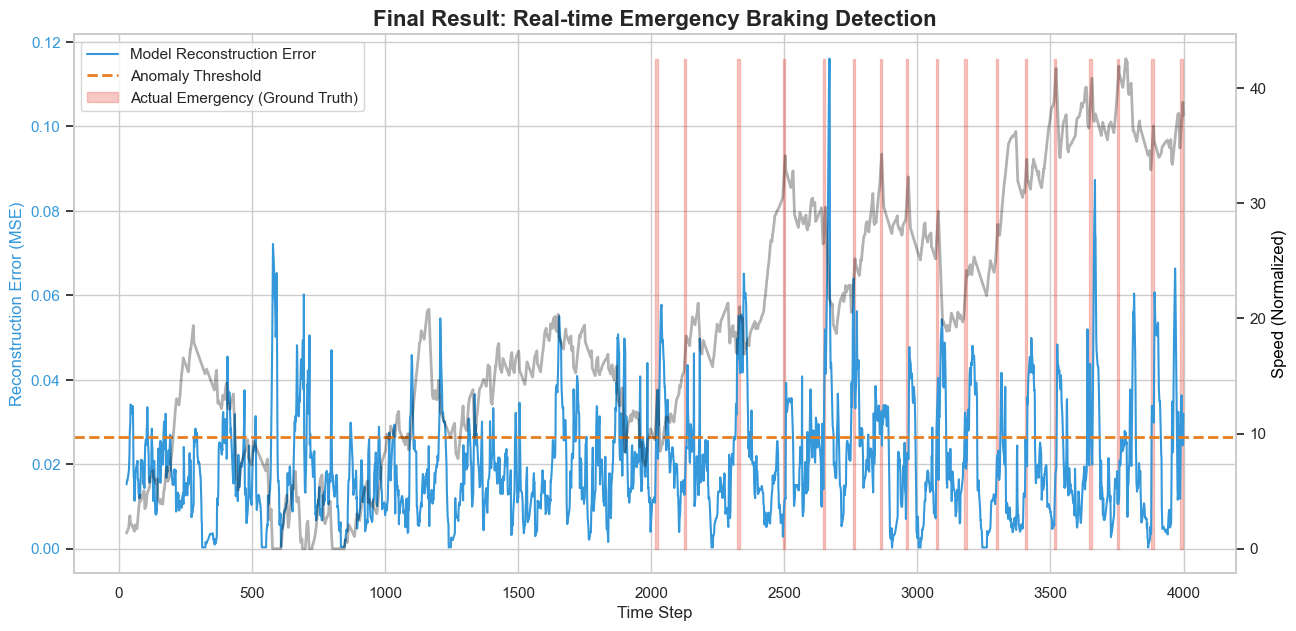

In [ ]:
# --- PREPARE TIME SERIES DATA ---
# We align the MSE to the indices of the original dataframe
# (Note: we lose the first WINDOW_SIZE rows due to sliding windows)
plot_indices = df_test.index[WINDOW_SIZE:]
test_labels = df_test["label"].values[WINDOW_SIZE:]

# --- PLOT 3: ANOMALY DETECTION OVER TIME ---
fig, ax1 = plt.subplots(figsize=(15, 7))

# 1. Plot Reconstruction Error (The "AI Signal")
ax1.plot(plot_indices, mse_test, label="Model Reconstruction Error", color="#3498db", linewidth=1.5)
ax1.set_ylabel("Reconstruction Error (MSE)", color="#3498db", fontsize=12)
ax1.tick_params(axis='y', labelcolor="#3498db")

# 2. Plot Threshold
ax1.axhline(threshold, color=COLORS['threshold'], linestyle="--", linewidth=2, label="Anomaly Threshold")

# 3. Overlay Ground Truth (The "Reality")
# We fill the background red wherever label == 1
# This requires finding start/end points of anomalies
anom_flags = (test_labels == 1)
ax1.fill_between(plot_indices, 0, max(mse_test), where=anom_flags, 
                 color=COLORS['anomaly'], alpha=0.3, label="Actual Emergency (Ground Truth)")

# 4. (Optional) Overlay Speed on secondary axis for context
ax2 = ax1.twinx()
speed_vals = df_test["speed"].values[WINDOW_SIZE:]
ax2.plot(plot_indices, speed_vals, color="black", alpha=0.3, linewidth=2, label="Vehicle Speed")
ax2.set_ylabel("Speed (Normalized)", color="black")
ax2.grid(False) # Turn off grid for secondary axis to avoid clutter

# Labels and Title
plt.title("Final Result: Real-time Emergency Braking Detection", fontsize=16, fontweight='bold')
ax1.legend(loc="upper left")
ax1.set_xlabel("Time Step")

# Zoom in on a busy section (Optional: adjust slicing to see specific area)
# plt.xlim(2000, 3000) 

plt.show()

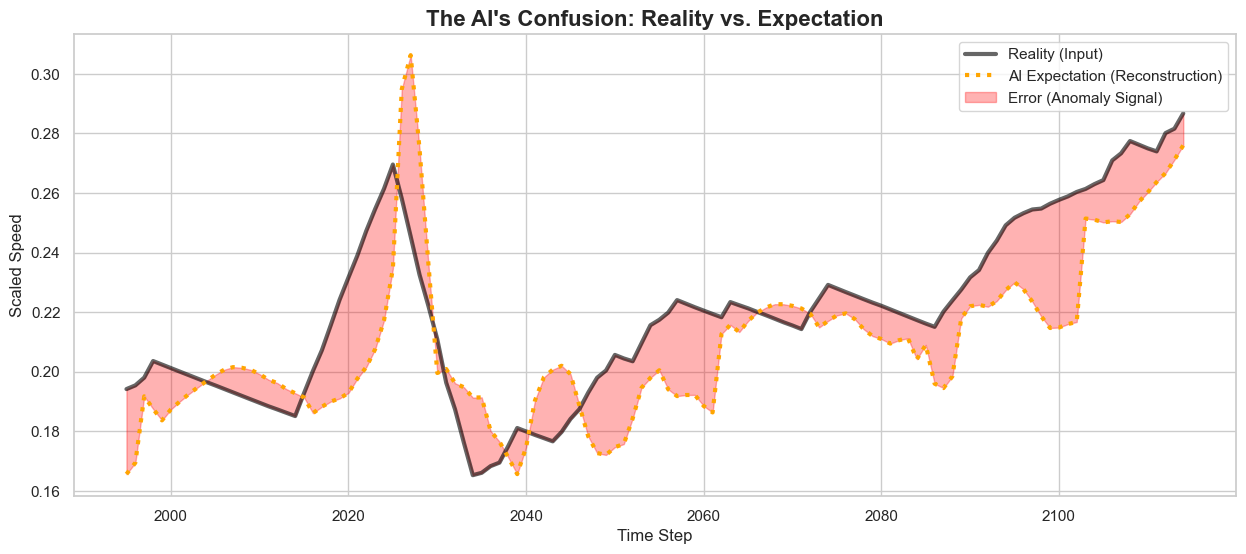

In [ ]:
# --- NEW PLOT: REALITY VS RECONSTRUCTION ---
# We use the same subset window from above

# 1. Get the model's opinion on this specific window
# We need to scale it first because the model expects scaled data
subset_vals = subset[["speed", "gas", "brake"]].values
subset_scaled = scaler.transform(subset_vals)
subset_windows = create_sliding_windows(subset_scaled, WINDOW_SIZE)
subset_tensor = torch.FloatTensor(subset_windows)

with torch.no_grad():
    reconstructed_windows = model(subset_tensor)

# The model output is sliding windows. We take the LAST point of each window to plot a time series.
# (This aligns with how we calculate error)
rec_flat = reconstructed_windows[:, -1, :].numpy()

# Align time indices (we lose the first WINDOW_SIZE steps)
time_index = subset.index[WINDOW_SIZE:]
real_speed = subset_scaled[WINDOW_SIZE:, 0] # Index 0 is speed
ai_speed = rec_flat[:, 0]

# PLOT
plt.figure(figsize=(15, 6))
plt.plot(time_index, real_speed, color='black', linewidth=3, alpha=0.6, label="Reality (Input)")
plt.plot(time_index, ai_speed, color='orange', linestyle=':', linewidth=3, label="AI Expectation (Reconstruction)")

# Highlight difference
plt.fill_between(time_index, real_speed, ai_speed, color='red', alpha=0.3, label="Error (Anomaly Signal)")

plt.title("The AI's Confusion: Reality vs. Expectation", fontsize=16, fontweight='bold')
plt.xlabel("Time Step")
plt.ylabel("Scaled Speed")
plt.legend()
plt.show()

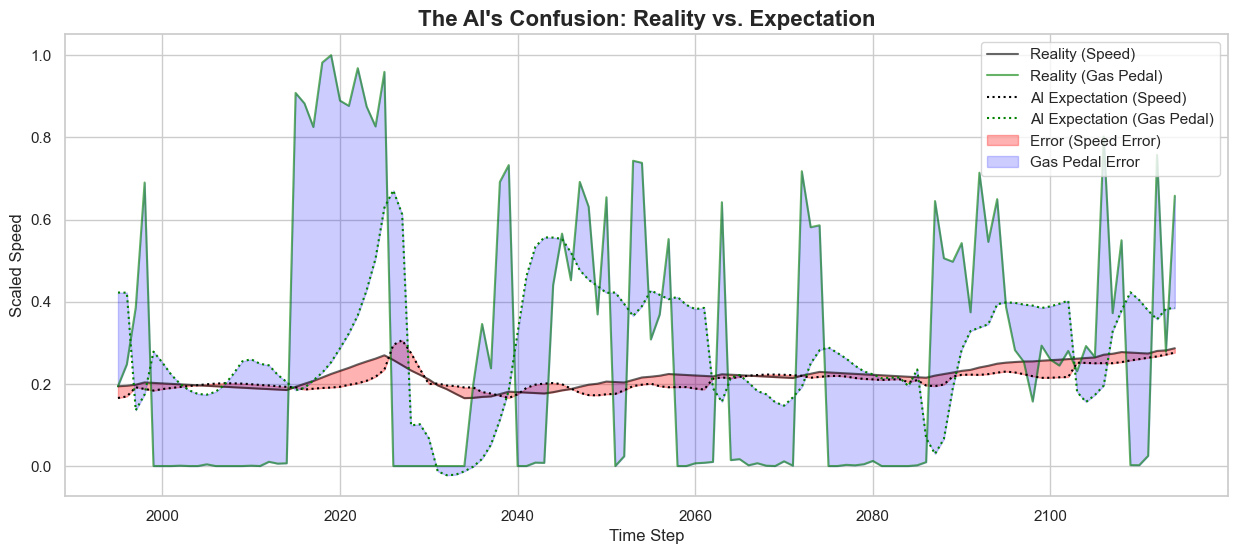

In [ ]:
# --- NEW PLOT: REALITY VS RECONSTRUCTION ---
# We use the same subset window from above

# 1. Get the model's opinion on this specific window
# We need to scale it first because the model expects scaled data
subset_vals = subset[["speed", "gas", "brake"]].values
subset_scaled = scaler.transform(subset_vals)
subset_windows = create_sliding_windows(subset_scaled, WINDOW_SIZE)
subset_tensor = torch.FloatTensor(subset_windows)

with torch.no_grad():
    reconstructed_windows = model(subset_tensor)

# The model output is sliding windows. We take the LAST point of each window to plot a time series.
# (This aligns with how we calculate error)
rec_flat = reconstructed_windows[:, -1, :].numpy()

# Align time indices (we lose the first WINDOW_SIZE steps)
time_index = subset.index[WINDOW_SIZE:]
real_speed = subset_scaled[WINDOW_SIZE:, 0] # Index 0 is speed
real_gas = subset_scaled[WINDOW_SIZE:, 1]  # Index 1 is gas
real_brake = subset_scaled[WINDOW_SIZE:, 2]  # Index 2 is brake

ai_speed = rec_flat[:, 0]
ai_gas = rec_flat[:, 1]
ai_brake = rec_flat[:, 2]

# PLOT
plt.figure(figsize=(15, 6))
plt.plot(time_index, real_speed, color='black', linewidth=1.5, alpha=0.6, label="Reality (Speed)")
plt.plot(time_index, real_gas, color='green', linewidth=1.5, alpha=0.6, label="Reality (Gas Pedal)")
# plt.plot(time_index, real_brake, color='red', linewidth=1.5, alpha=0.6, label="Reality (Brake Pedal)")


plt.plot(time_index, ai_speed, color='black', linestyle=':', linewidth=1.5, label="AI Expectation (Speed)")
plt.plot(time_index, ai_gas, color='green', linestyle=':', linewidth=1.5, label="AI Expectation (Gas Pedal)")
# plt.plot(time_index, ai_brake, color='orange', linestyle=':', linewidth=1.5, label="AI Expectation (Brake Pedal)")

# Highlight difference
plt.fill_between(time_index, real_speed, ai_speed, color='red', alpha=0.3, label="Error (Speed Error)")
plt.fill_between(time_index, real_gas, ai_gas, color='blue', alpha=0.2, label="Gas Pedal Error")
# plt.fill_between(time_index, real_brake, ai_brake, color='purple', alpha=0.2, label="Brake Pedal Error")

plt.title("The AI's Confusion: Reality vs. Expectation", fontsize=16, fontweight='bold')
plt.xlabel("Time Step")
plt.ylabel("Scaled Speed")
plt.legend()
plt.show()

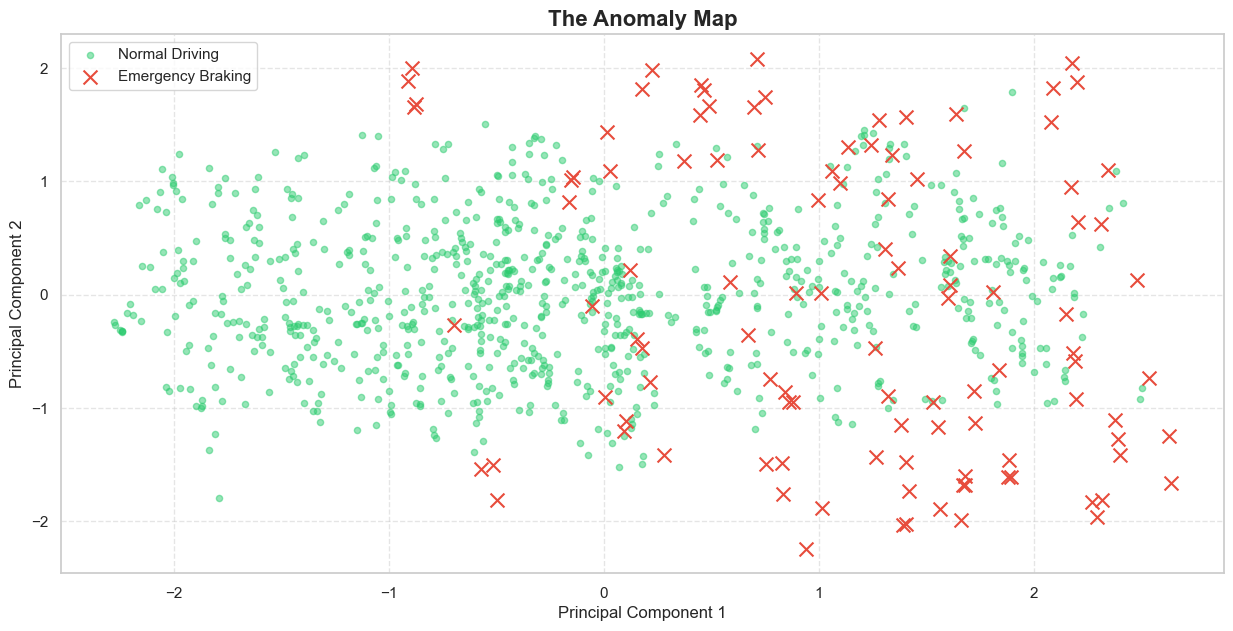

In [ ]:
from sklearn.decomposition import PCA

# --- FIX: DEFINE LABELS (y_test) ---
# We need to apply the same sliding window to the labels
# Logic taken from your main_test.py: A window is "Anomaly" if it has >= 8 crash frames
test_labels_raw = df_test["label"].values
label_windows = create_sliding_windows(test_labels_raw, WINDOW_SIZE)

# Sum the anomalies in each window. If >= 8, mark the whole window as 1 (Crash)
y_test = (label_windows.sum(axis=1) >= 8).astype(int)

# --- NOW RUN THE PCA PLOT ---
# 1. Subsample (Take 1000 random points so the plot isn't a mess)
# Ensure we don't try to take more points than we actually have
num_samples = min(1000, len(X_test))
sample_idx = np.random.choice(len(X_test), num_samples, replace=False)

X_sample = X_test[sample_idx]
y_sample = y_test[sample_idx]

# 2. Flatten: (Batch, Window, Features) -> (Batch, Window*Features)
# We squash the 30x3 matrix into a single line of 90 numbers for PCA
X_flat = X_sample.reshape(X_sample.shape[0], -1)

# 3. Run PCA (Squash 90 dimensions down to 2)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flat)

# 4. Plot
plt.figure(figsize=(15, 7))

# Plot Normal dots (Green)
plt.scatter(X_pca[y_sample==0, 0], X_pca[y_sample==0, 1], 
            c='#2ecc71', alpha=0.5, label='Normal Driving', s=20)

# Plot Crash dots (Red X)
plt.scatter(X_pca[y_sample==1, 0], X_pca[y_sample==1, 1], 
            c='#e74c3c', s=100, marker='x', label='Emergency Braking')

plt.title("The Anomaly Map", fontsize=16, fontweight='bold')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

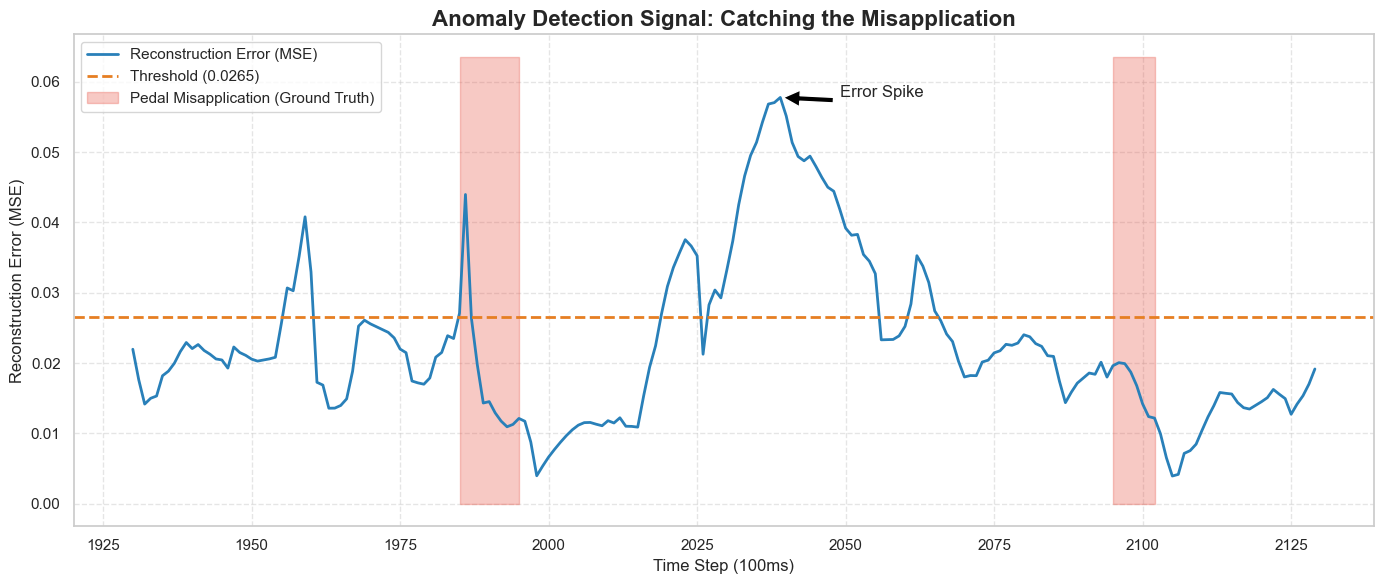

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- CONFIGURATION ---
# Zoom in on a specific window to see the spike clearly
# (Adjust these indices based on where your anomaly actually is in df_test)
START_IDX = 1900 
END_IDX = 2100

# Slice the data for the zoom view
# Note: We offset by WINDOW_SIZE because the first 30 points don't have an error score
zoom_slice = slice(START_IDX, END_IDX)
time_axis = df_test.index[WINDOW_SIZE:][zoom_slice]
error_data = mse_test[zoom_slice]
labels_data = test_labels[WINDOW_SIZE:][zoom_slice]

# --- THE PLOT ---
plt.figure(figsize=(14, 6))

# 1. PLOT THE ERROR SIGNAL (The Blue Line)
# This is the "Heartbeat" of your model. 
# Low = Confident, High = Confused (Anomaly).
plt.plot(time_axis, error_data, label='Reconstruction Error (MSE)', 
         color='#2980b9', linewidth=2)

# 2. PLOT THE THRESHOLD (The Orange Line)
# Anything above this line triggers the emergency system.
plt.axhline(y=threshold, color='#e67e22', linestyle='--', linewidth=2, 
            label=f'Threshold ({threshold:.4f})')

# 3. HIGHLIGHT THE EVENT (The Red Zone)
# This uses the "label" column to shade the background Red 
# exactly when the pedal misapplication/emergency is happening.
plt.fill_between(time_axis, 0, np.max(error_data)*1.1, 
                 where=(labels_data == 1), 
                 color='#e74c3c', alpha=0.3, 
                 label='Pedal Misapplication (Ground Truth)')

# Styling
plt.title("Anomaly Detection Signal: Catching the Misapplication", fontsize=16, fontweight='bold')
plt.xlabel("Time Step (100ms)", fontsize=12)
plt.ylabel("Reconstruction Error (MSE)", fontsize=12)
plt.legend(loc='upper left', frameon=True)
plt.grid(True, linestyle='--', alpha=0.5)

# Optional: Add text annotation pointing to the spike
peak_time = time_axis[np.argmax(error_data)]
peak_val = np.max(error_data)
plt.annotate('Error Spike', xy=(peak_time, peak_val), xytext=(peak_time+10, peak_val),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.show()

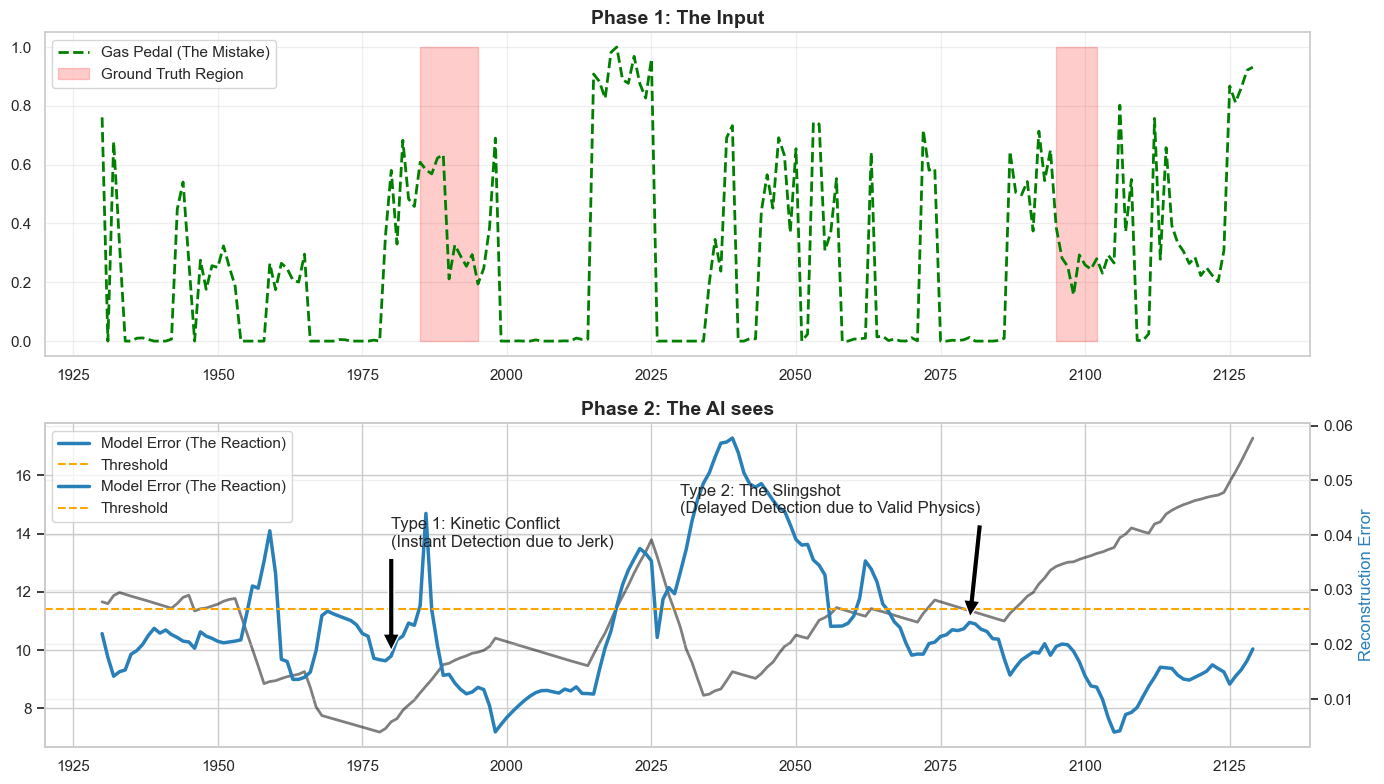

In [ ]:
# --- THE SLINGSHOT PROOF ---
# We use the same 'zoom_slice' from before to look at that specific event

plt.figure(figsize=(14, 8))

# 1. TOP PANEL: The Inputs (Cause)
plt.subplot(2, 1, 1)
plt.plot(time_axis, df_test["gas"].values[WINDOW_SIZE:][zoom_slice], 
         color='green', linestyle='--', linewidth=2, label='Gas Pedal (The Mistake)')
plt.fill_between(time_axis, 0, 1, where=(labels_data == 1), 
                 color='red', alpha=0.2, label='Ground Truth Region')
plt.title("Phase 1: The Input", fontsize=14, fontweight='bold')
plt.legend(loc="upper left")
plt.grid(True, alpha=0.3)

# 2. BOTTOM PANEL: The Consequence (Speed & Error)
plt.subplot(2, 1, 2)
# Plot Speed (Normalized/Scaled for comparison)
speed_data = df_test["speed"].values[WINDOW_SIZE:][zoom_slice]
plt.plot(time_axis, speed_data, color='black', alpha=0.5, linewidth=2, label='Vehicle Speed (The Consequence)')

# Plot Error (Right Axis)
ax2 = plt.gca().twinx()
ax2.plot(time_axis, error_data, color='#2980b9', linewidth=2.5, label='Model Error (The Reaction)')
ax2.axhline(threshold, color='orange', linestyle='--', label='Threshold')
ax2.set_ylabel("Reconstruction Error", color='#2980b9')

plt.title("Phase 2: The AI sees", fontsize=14, fontweight='bold')
plt.xlabel("Time Step")

# Combine legends
lines, labels = plt.gca().get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines + lines2, labels + labels2, loc="upper left")
plt.grid(True, alpha=0.3)

plt.tight_layout()

# ... (Your plotting code) ...

# Annotation for the First Anomaly
plt.annotate('Type 1: Kinetic Conflict\n(Instant Detection due to Jerk)', 
             xy=(time_axis[50], error_data[50]), # Adjust index to point to first spike
             xytext=(time_axis[50], error_data[50] + 0.02),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Annotation for the Second Anomaly
plt.annotate('Type 2: The Slingshot\n(Delayed Detection due to Valid Physics)', 
             xy=(time_axis[-50], error_data[-50]), # Adjust index to point to second spike
             xytext=(time_axis[-50]-50, error_data[-50] + 0.02),
             arrowprops=dict(facecolor='black', shrink=0.05))


plt.show()
